In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import seaborn as sns

In [2]:
# load dataset
df=pd.read_csv("IMDB_Dataset.csv")

In [3]:
df = pd.read_csv('IMDB_Dataset.csv')

def clean_text(text):
    text = re.sub('<.*?>','',text)
    text = re.sub('[^a-zA-Z]',' ',text)
    return text.lower().strip()

df['clean_review'] = df['review'].apply(clean_text)
df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0})
df.head()


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,a wonderful little production the filming tec...
2,I thought this was a wonderful way to spend ti...,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei s love in the time of money is...


In [4]:
df.tail()

,review,sentiment,clean_review
49995,I thought this movie did a down right good job...,1,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,bad plot bad dialogue bad acting idiotic di...
49997,I am a Catholic taught in parochial elementary...,0,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,0,i m going to have to disagree with the previou...
49999,No one expects the Star Trek movies to be high...,0,no one expects the star trek movies to be high...


In [5]:
df['sentiment'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
49995    False
49996    False
49997    False
49998    False
49999    False
Name: sentiment, Length: 50000, dtype: bool

In [6]:
df['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [7]:
df['clean_review'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
49995    False
49996    False
49997    False
49998    False
49999    False
Name: clean_review, Length: 50000, dtype: bool

### Crrate x and y veriables

In [8]:
#crrate x and y veriables
x=df['clean_review']


In [9]:
y=df['sentiment']
y.value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

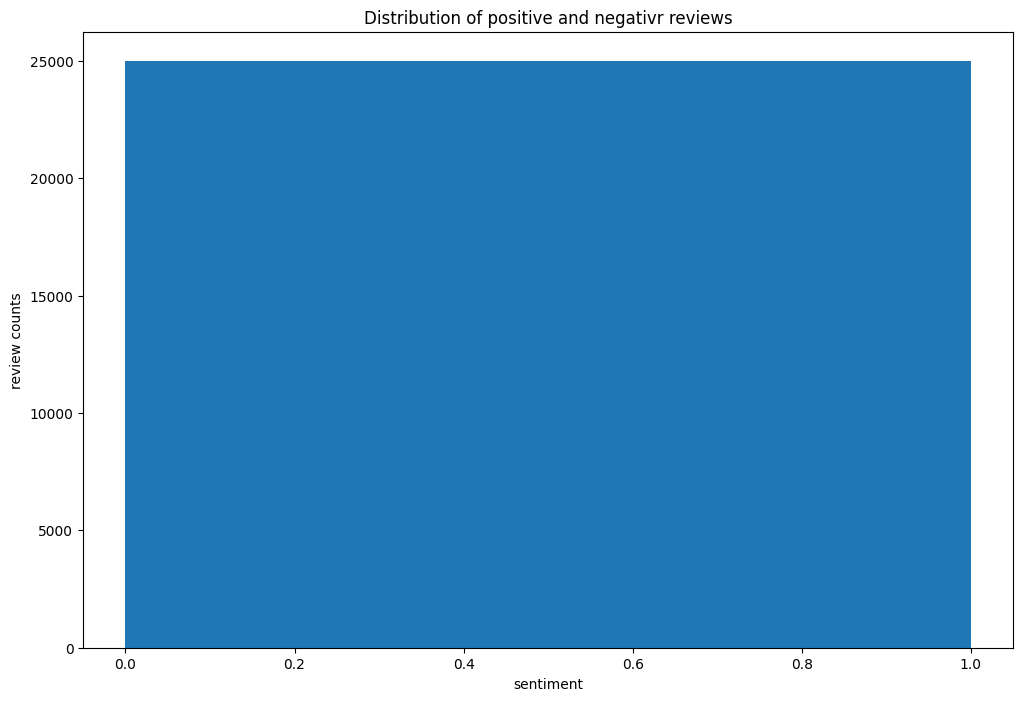

In [10]:
plt.figure(figsize=(12,8))
plt.hist(y,bins=2)
plt.xlabel("sentiment")
plt.ylabel("review counts")
plt.title("Distribution of positive and negativr reviews")
plt.show()

### Split into Train and Test Sets

In [11]:
#split into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [12]:
len(x_train),len(x_test),len(y_train),len(y_test)

(40000, 10000, 40000, 10000)

### Tokanize our data

In [13]:
#tokanize our data
def tokanize(x):
    return x.split()
word_freq={}
for r in x_train:
    for w in tokanize(r):
        word_freq[w]=word_freq.get(w,0)+1
vocab={'<PAD>':0,'<UNK>':1}
for w,f in word_freq.items():
    if f>=5:
        vocab[w]=len(vocab)
def numericalize(text):
    return [vocab.get(w,1) for w in tokanize(text)]

len(vocab)
        
        

35707

### Turns raw text
    *numbers
    *same-length sequences
    *batches of data
    *ready for training a deep learning model

In [14]:

class IMDBdataset(Dataset):
    def __init__(self,review,label,max_len=200):
        self.review=list(review)
        self.label=list(label)
        self.max_len=max_len

    def pad(self,seq):
        return seq[:self.max_len]+[0]*(self.max_len-len(seq)) if len(seq)<self.max_len else seq[:self.max_len]
    def __getitem__(self,idx):
            seq=numericalize(self.review[idx])
            seq=self.pad(seq)
            return torch.tensor(seq),torch.tensor(self.label[idx])
    def __len__(self):
        return len(self.review)

### Pass our data through our IMDB dataset class

In [15]:
#pass our data through our IMDB dataset class
train_dataset=IMDBdataset(x_train,y_train)
test_dataset=IMDBdataset(x_test,y_test)


In [16]:
len(train_dataset),len(test_dataset)

(40000, 10000)

### Turn our data to dataloaders

In [17]:
#turn our data to dataloaders
train_data_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_data_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [18]:
len(train_data_loader),len(test_data_loader)

(1250, 313)

In [19]:
40000/32

1250.0

In [20]:
10000/32

312.5

### Create a model in pytroch 
    Arichticture of our model
    *Embeding layer:embeding layer convert every one dimentional number into a vector of numbers between one and zero.  
    *LSTM layer:LSTM is like a memroy it read a sentence word by word and moemorize the important impornation of our model.  
    *fully connected Layer(Linear):our lstm layer output 128 numbers so our linear layer out put it to a single number.  
    *sigmoid function :sigmoid function convert and number to output probability between (0-1)
    

In [66]:
class sentimentmodel(nn.Module):
    def __init__(self,vocab_size,embed_dim=128,hidden_dim=128):
        super(). __init__()
        self.embedding=nn.Embedding(vocab_size,embed_dim)
        self.lstm=nn.LSTM(embed_dim,hidden_dim,batch_first=True)
        self.fc=nn.Linear(hidden_dim,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self,x):
        return self.sigmoid(self.fc(self.lstm(self.embedding(x))[0][:,-1:,:]))

In [67]:
model_4=sentimentmodel(len(vocab))

### set loss function and optimizer
    we will use BCEloss (beacuse this is a classification problem).  
    and Adam optimizer (because its and ahve good default hyperparameter values)
    

In [23]:
loss_fn=nn.BCELoss()
optimizer=torch.optim.Adam(params=model_4.parameters(),lr=0.001)

### Training and Testing loop

In [24]:
epochs = 40

epoch_losses = []     # to store loss of each epoch
epoch_accuracies = [] # to store accuracy of each epoch

for epoch in range(epochs):
    model_4.train()
    total_loss = 0
    correct = 0
    total = 0

    for rev, lab in tqdm(train_data_loader):

        pred = model_4(rev).squeeze()

        # loss
        loss = loss_fn(pred, lab.float())
        total_loss += loss.item()

        # accuracy
        predicted = (pred > 0.5).long()
        correct += (predicted == lab).sum().item()
        total += lab.size(0)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # store epoch results
    avg_loss = total_loss / len(train_data_loader)
    acc = correct / total

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [03:36<00:00,  5.78it/s]


Epoch 1/40 | Loss: 0.6899 | Accuracy: 0.5272


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:13<00:00,  9.40it/s]


Epoch 2/40 | Loss: 0.6075 | Accuracy: 0.6417


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:09<00:00,  9.66it/s]


Epoch 3/40 | Loss: 0.3284 | Accuracy: 0.8636


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:07<00:00,  9.82it/s]


Epoch 4/40 | Loss: 0.2282 | Accuracy: 0.9119


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:06<00:00,  9.85it/s]


Epoch 5/40 | Loss: 0.1604 | Accuracy: 0.9415


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:07<00:00,  9.78it/s]


Epoch 6/40 | Loss: 0.1038 | Accuracy: 0.9658


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:08<00:00,  9.76it/s]


Epoch 7/40 | Loss: 0.0654 | Accuracy: 0.9804


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:09<00:00,  9.66it/s]


Epoch 8/40 | Loss: 0.0414 | Accuracy: 0.9886


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:19<00:00,  8.93it/s]


Epoch 9/40 | Loss: 0.0310 | Accuracy: 0.9917


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:29<00:00,  8.38it/s]


Epoch 10/40 | Loss: 0.0215 | Accuracy: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [02:36<00:00,  7.96it/s]


Epoch 11/40 | Loss: 0.0172 | Accuracy: 0.9952


  4%|███▎                                                                            | 51/1250 [00:06<02:31,  7.94it/s]


KeyboardInterrupt: 

In [25]:
test_accuracies = []

model_4.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for rev, lab in test_data_loader:
        pred = (model_4(rev).squeeze() > 0.5).long()

        correct += (pred == lab).sum().item()
        total += lab.size(0)

        y_pred.extend(pred.tolist())
        y_true.extend(lab.tolist())

    test_acc = correct / total
    test_accuracies.append(test_acc)

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8636


### we can create a input fuction fro avoiding converting and stups 

In [26]:
model_4.eval()
def input(text,model):
    text=clean_text(text)
    seq=numericalize(text)
    seq=seq[:200]+[0]*(200-len(seq))
    seq=torch.tensor(seq).unsqueeze(0)
    # model.eval()
    with torch.no_grad():
        pred = model(seq).item()
    return 'positve' if pred>=0.5 else 'negative'

In [27]:
input("I really loved this movie! The story was amazing, the acting was great, and I enjoyed every moment.",model_4)

'positve'

In [28]:
input("This movie was terrible. The plot made no sense, the acting was bad, and I got bored quickly.",model_4)

'negative'

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(y_true,y_pred)

array([[4238,  723],
       [ 641, 4398]], dtype=int64)

### let's prettify our our confusion matrix and functunize it

In [31]:
def prety_matrix(y_true,y_pred,label=None,title="Confusion Matrix"):
    cm=confusion_matrix(y_true,y_pred)
    if label is None:
        label=np.unique(np.concatenate([y_true,y_pred]))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm,annot=True,fmt='d',cmap="Blues",xticklabels=label,yticklabels=label)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.legend()
    plt.show()
    

C:\Users\hp 840 G5\AppData\Local\Temp\ipykernel_4356\689758599.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


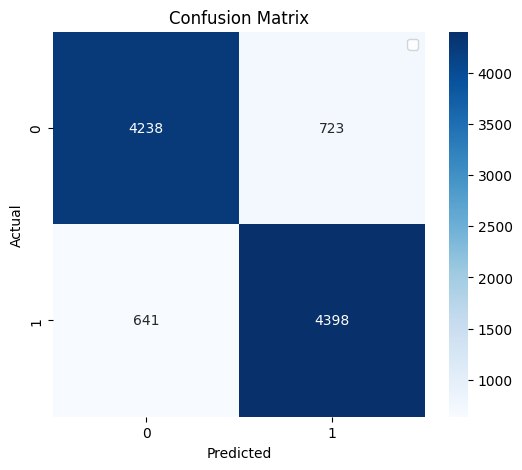

In [32]:
prety_matrix(y_true,y_pred)

### Save our model

In [33]:
#save only our model sate dict
torch.save(model_4.state_dict(),"sentiment_model_weights_1.pth")

In [35]:
model_33=torch.load("sentiment_model_weights_1.pth")

In [36]:
vocab_size=len(vocab)

In [42]:
model_5=sentimentmodel(vocab_size)
model_4.load_state_dict(torch.load("sentiment_model_weights_1.pth"))
model_4.eval()

sentimentmodel(
  (embedding): Embedding(35707, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [43]:
import pickle 
with open("vocab.pkl","wb") as f:
    pickle.dump(vocab, f)

In [44]:

with open("vocab.pkl","rb")as f:
    vocab=pickle.load(f)

In [45]:
import os
os.listdir()


['.ipynb_checkpoints',
 'full_model_5.pth',
 'IMDB_Dataset.csv',
 'IMDB_Dataset_copy.csv',
 'IMDB_Dataset_copy.zip',
 'moive_sentimrent_analysis_1.ipynb',
 'sentiment_model_weights.pth',
 'sentiment_model_weights_1.pth',
 'Untitled.ipynb',
 'vocab.pkl']

In [46]:
input("I absolutely loved this movie! The story was emotional, the acting was fantastic, and the direction was brilliant.",model_5)


'positve'

In [47]:
input("One of the best films I have watched this year. Beautiful cinematography and a very powerful message.",model_5)

'positve'

In [ ]:
positive_reviews = [
    "I absolutely loved this movie, the story was beautiful.",
    "Amazing acting and a very emotional storyline.",
    "This film was inspiring and brilliantly directed.",
    "A wonderful movie with great character development.",
    "The visuals were stunning and the soundtrack was perfect.",
    "One of the best movies I’ve seen this year.",
    "Beautifully made, emotional, and deeply engaging.",
    "The plot was creative and very well executed.",
    "A powerful and uplifting cinematic experience.",
    "The film exceeded all my expectations."
]

In [49]:
input("I really disliked this movie, the story was boring.",model_5)

'positve'

### Look like our model is over fitting means it memrize our training data And doing poor on unseen data.  so we ahve to recreate our model and evaluate performene

In [102]:
class SentimentModelV1(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            bidirectional=True, batch_first=True)

        self.drop = nn.Dropout(0.3)

        self.fc = nn.Linear(hidden_dim * 2, 1)  #
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = [batch, seq_len]
        emb = self.embedding(x)

        out, (h_n, c_n) = self.lstm(emb)

        h_forward = h_n[-2]     
        h_backward = h_n[-1]    

        h = torch.cat((h_forward, h_backward), dim=1)  # 

        h = self.drop(h)
        return self.sigmoid(self.fc(h)).squeeze(1)  


In [103]:
sentimentmodel=SentimentModelV1(len(vocab))

### Setup loss Function and Optimizer

In [104]:
loss_fn=nn.BCELoss()
optimizer=torch.optim.Adam(params=sentimentmodel.parameters())

###  set up Traning and Testing loop

In [105]:
epochs = 10
epoch_losses = []
epoch_accuracies = []

for epoch in range(epochs):

    sentimentmodel.train()
    total_loss = 0
    correct = 0
    total = 0

    for rev, lab in tqdm(train_data_loader):

        pred = sentimentmodel(rev)   # shape: [batch]

        loss = loss_fn(pred.squeeze(), lab.float())
        total_loss += loss.item()

        predicted = (pred > 0.5).long()
        correct += (predicted == lab).sum().item()
        total += lab.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_data_loader)
    acc = correct / total

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")



100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [14:44<00:00,  1.41it/s]


Epoch 1/10 | Loss: 0.6576 | Accuracy: 0.6028


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:33<00:00,  3.18it/s]


Epoch 2/10 | Loss: 0.6129 | Accuracy: 0.6523


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:28<00:00,  3.22it/s]


Epoch 3/10 | Loss: 0.3600 | Accuracy: 0.8497


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:27<00:00,  3.23it/s]


Epoch 4/10 | Loss: 0.2506 | Accuracy: 0.9027


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:30<00:00,  3.20it/s]


Epoch 5/10 | Loss: 0.1766 | Accuracy: 0.9369


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:27<00:00,  3.23it/s]


Epoch 6/10 | Loss: 0.1219 | Accuracy: 0.9580


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:20<00:00,  3.29it/s]


Epoch 7/10 | Loss: 0.0758 | Accuracy: 0.9763


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [07:21<00:00,  2.83it/s]


Epoch 8/10 | Loss: 0.0474 | Accuracy: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:33<00:00,  3.18it/s]


Epoch 9/10 | Loss: 0.0309 | Accuracy: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [06:34<00:00,  3.17it/s]

Epoch 10/10 | Loss: 0.0218 | Accuracy: 0.9929


In [137]:
# tesing loop
test_ac=[]
sentimentmodel.eval()
correct = 0
total = 0
test_loss =0

with torch.no_grad():
    for rev, lab in test_data_loader:

        pred = sentimentmodel(rev)  # shape: [batch]

        test_loss += loss_fn(pred, lab.float()).item()

        predicted = (pred > 0.5).long()
        correct += (predicted == lab).sum().item()
        total += lab.size(0)

test_acc = correct / total
test_loss = test_loss / len(test_data_loader)
test_ac.append(test_acc)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")



Test Loss: 0.7398 | Test Accuracy: 0.8575


In [108]:
sentimentmodel.eval()
input("The visuals were stunning and the soundtrack was perfect.",sentimentmodel)

'positve'

In [109]:
input("The film exceeded all my expectations.",sentimentmodel)

'positve'

### confusion matrix

<Figure size 600x500 with 0 Axes>

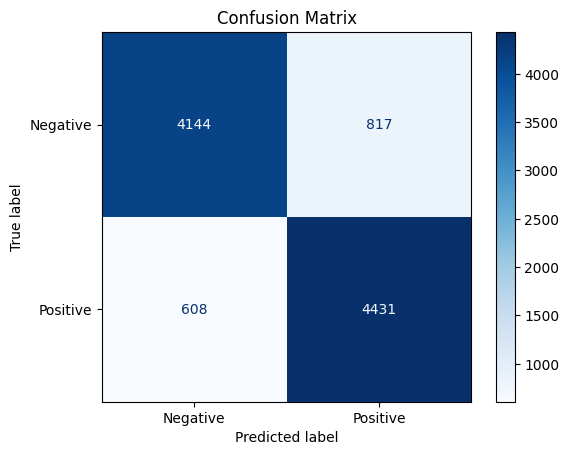

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true = []
y_pred = []
sentimentmodel.eval()
with torch.no_grad():
    for rev, lab in test_data_loader:
        pred = sentimentmodel(rev)
        predicted = (pred.squeeze() > 0.5).long()
        y_true.extend(lab.tolist())
        y_pred.extend(predicted.tolist())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


### Loss Curves And Accruacy curves

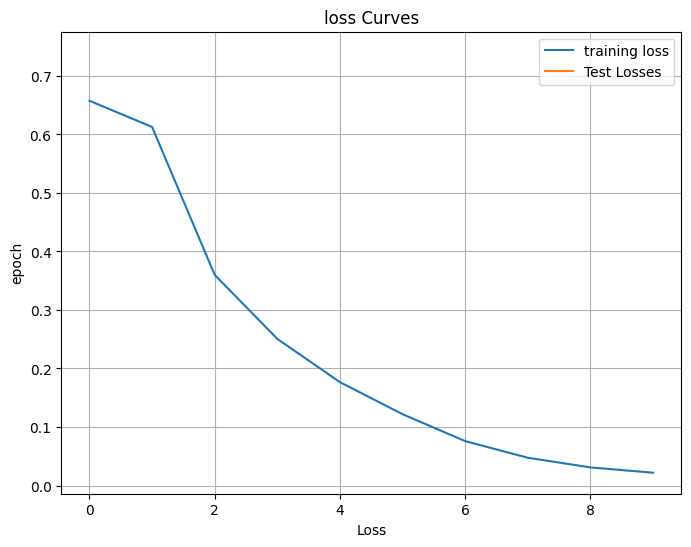

In [123]:
#loss curves
plt.figure(figsize=(8,6))
plt.plot(epoch_losses,label="training loss")
plt.plot(test_loss,label="Test Losses")
plt.title("loss Curves")
plt.ylabel("epoch")
plt.xlabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Accuracy curve

In [126]:
test_loss

0.7397524280988347

In [140]:
test_ac


[0.8575]

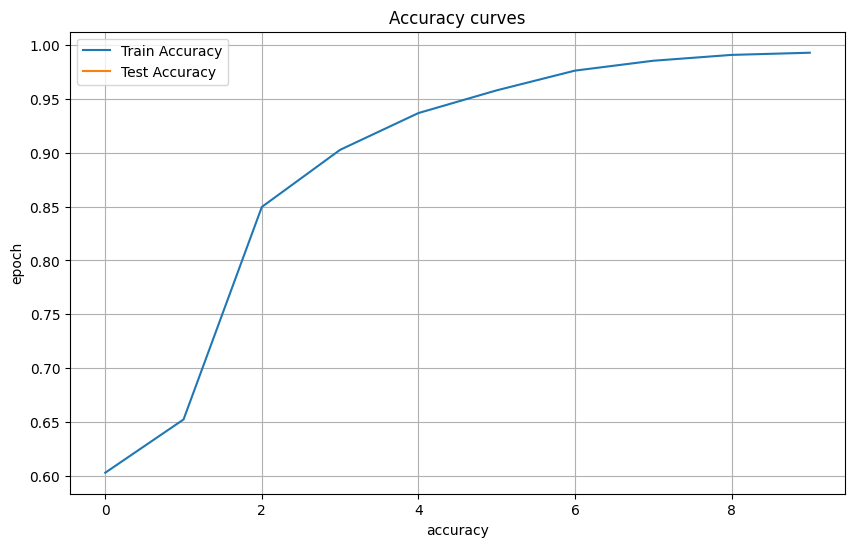

<Figure size 640x480 with 0 Axes>

In [145]:
plt.figure(figsize=(10,6))
plt.plot(epoch_accuracies,label="Train Accuracy")
plt.plot(test_ac,label="Test Accuracy")
plt.title("Accuracy curves")
plt.ylabel("epoch")
plt.xlabel("accuracy")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("train_loss_curve.png", dpi=300)


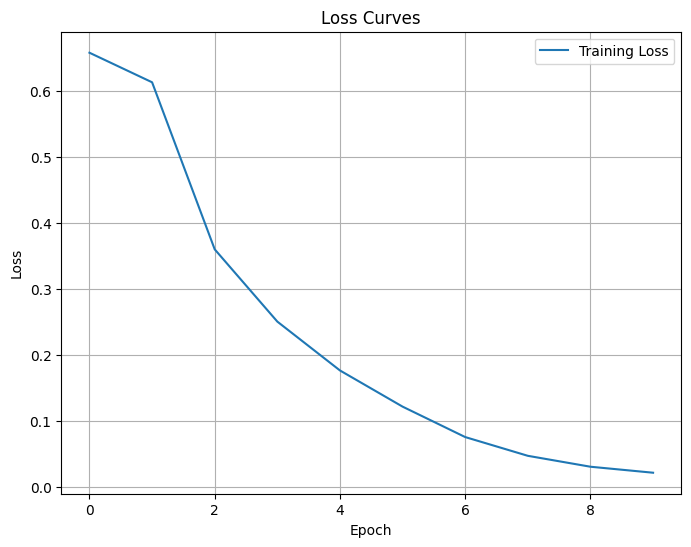

<Figure size 640x480 with 0 Axes>

In [147]:
plt.figure(figsize=(8,6))

plt.plot(range(len(epoch_losses)), epoch_losses, label="Training Loss")


plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("train_accuracy_curve.png", dpi=300)
plt.show()

### save our model

In [148]:
torch.save(sentimentmodel.state_dict(),"imporved_model_1.pth")